In [41]:
import sys
sys.path.append('../')

from utils.processing import *
from utils.visualisation import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import DBSCAN

np.random.seed(0)

In [42]:
def prepare_data_for_regression(df, drop_columns=[]):
    adfs = read_aux_csv('../data')
    df = join_aux(df, adfs)
    df = df.drop(columns=drop_columns)

    return df

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    score = np.sqrt(mse)
    return score

def rmse_scorer():
    return make_scorer(rmse, greater_is_better=False)

initial_drop_columns = [
        'address',
        'title',
        'listing_id',
        'property_name',
        'available_unit_types',
        'property_details_url',
        'elevation',
        'tenure',
        'property_type',
        'floor_level',
        'furnishing',
        # remove 
        'planning_area'
    ] + [
    #'subzone',
    #'planning_area',
    #'region',
    'lat',
    'lng',
    'floor_level_ground',
    'floor_level_high',
    'floor_level_low',
    'floor_level_mid',
    'floor_level_penthouse',
    'floor_level_top',
    'furnishing_partial',
    'furnishing_unfurnished',
    'furnishing_unspecified',
    'line_cc',
    'line_ce',
    'line_cg',
    'line_dt',
    'line_ew',
    'line_ne',
    'line_ns',
    'line_te',
    'gep_pri_sch_within_1km',
    'gep_pri_sch_within_1km_2km',
    'cc_type_CR',
    'cc_type_IEBP',
    'cc_type_IHL',
]

In [43]:
df = pd.read_csv('../data/train.csv')
df = preprocess(df.copy())
df = prepare_data_for_regression(df, drop_columns=initial_drop_columns)

df_train, df_valid = train_test_split(df, test_size=0.30)

In [44]:
ct = make_column_transformer(
                    (make_pipeline(StandardScaler(), KNNImputer()), ['num_beds', 'num_baths', 'built_year', 'total_num_units']),
                    (StandardScaler(), ['nearest_mrt_distance_in_km', 'nearest_pri_sch_distance_in_km', 'nearest_gep_pri_sch_distance_in_km', 'nearest_com_centre_distance_in_km', 'nearest_mall_distance_in_km', 'area_size', 'population', 'density']),
                    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ["region", "subzone"]),
                    remainder='passthrough')

def ttr(pipeline):
    return TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

def transform_data(df):
    p = make_pipeline(ct)
    p.fit(df)
    
    return pd.DataFrame(data=p.transform(df), columns=p.get_feature_names_out())

In [45]:
X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

X_valid = df_valid.drop('price', axis=1)
y_valid = df_valid['price']

In [46]:
transformer = make_pipeline(ct)
transformer.fit(X_train)

t_X_train = pd.DataFrame(data=transformer.transform(X_train), columns=transformer.get_feature_names_out())
t_X_valid = pd.DataFrame(data=transformer.transform(X_valid), columns=transformer.get_feature_names_out())

In [47]:
t_X_train.shape, t_X_valid.shape

((14101, 269), (6044, 269))

In [48]:
# df = pd.read_csv('../data/train.csv')
# adfs = read_aux_csv('../data')
# df = join_aux(df, adfs)
# df = df.drop(columns=initial_drop_columns)

# df_train, df_valid = train_test_split(df, test_size=0.30)

# df_train = preprocess(df_train)
# df_valid = preprocess(df_valid, is_target=True)

# region_encoder = OneHotEncoder(handle_unknown="ignore")
# region_encoder.fit(df_train[['region']])
# df_train[region_encoder.categories_[0]] = region_encoder.transform(df_train[['region']]).toarray()
# df_train = df_train.drop(columns=['region'])

# df_valid[region_encoder.categories_[0]] = region_encoder.transform(df_valid[['region']]).toarray()
# df_valid = df_valid.drop(columns=['region'])

# planning_area_encoder = OneHotEncoder(handle_unknown="ignore")
# planning_area_encoder.fit(df_train[['planning_area']])
# df_train[planning_area_encoder.categories_[0]] = planning_area_encoder.transform(df_train[['planning_area']]).toarray()
# df_train = df_train.drop(columns=['planning_area'])

# df_valid[planning_area_encoder.categories_[0]] = planning_area_encoder.transform(df_valid[['planning_area']]).toarray()
# df_valid = df_valid.drop(columns=['planning_area'])

# df_train = df_train[df_train.columns[~df_train.columns.isna()]]
# df_train = df_train.select_dtypes(include=np.number)
# df_train = df_train.drop(columns=['listing_id', 'total_num_units', 'elevation', 'lat', 'lng'])

# df_valid = df_valid[df_train.columns]

# df_train.shape, df_valid.shape

In [49]:
pipe = Pipeline(steps=[('xgb', xgb.XGBRegressor())])

param_grid = {
    'xgb__max_depth': [10, 15, 20],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.05, 0.1, 0.3]
}
search = RandomizedSearchCV(pipe, param_grid, n_jobs=8, cv=5, scoring=rmse_scorer(), return_train_score=True)
search.fit(t_X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

#-729821.350
#-2252802.124 with planning area 

Best parameter (CV score=-2284934.030):
{'xgb__n_estimators': 100, 'xgb__min_child_weight': 5, 'xgb__max_depth': 20, 'xgb__learning_rate': 0.05}


In [50]:
y_pred = search.best_estimator_.predict(t_X_valid)
print(rmse(y_valid, y_pred))

1640125.2863879893


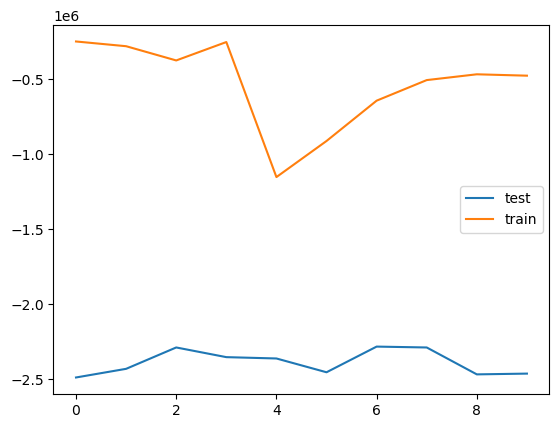

In [51]:
test_scores = search.cv_results_['mean_test_score']
train_scores = search.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

archive

In [18]:
pipe = Pipeline(steps=[('xgb', xgb.XGBRegressor())])

param_grid = {
    'xgb__max_depth': [10, 15, 20],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.1, 0.3, 0.5]
}
search = RandomizedSearchCV(pipe, param_grid, n_jobs=8, cv=10, scoring=rmse_scorer(), return_train_score=True)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

#-729821.350

Best parameter (CV score=-789384.954):
{'xgb__n_estimators': 150, 'xgb__min_child_weight': 3, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1}


In [19]:
y_pred = search.best_estimator_.predict(X_valid)
print(rmse(y_valid, y_pred))

507439855.59771645


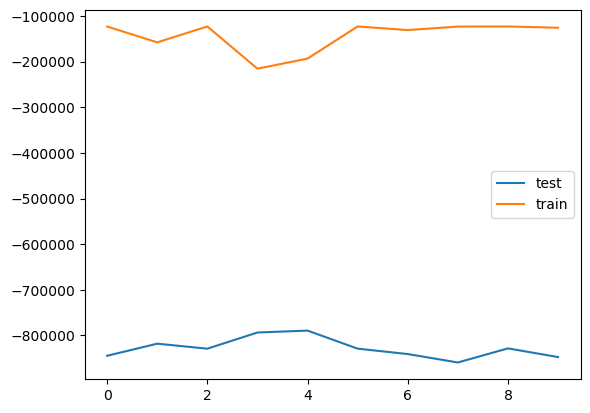

In [20]:
test_scores = search.cv_results_['mean_test_score']
train_scores = search.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [22]:
pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', Normalizer()), 
    ('pca', PCA()),
    ('xgb', xgb.XGBRegressor())]
)

param_grid = {
    "pca__n_components": [0.9, 0.93, 0.95],
    'xgb__max_depth': [5, 10, 15],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.1, 0.3, 0.5]
}
pca_search = RandomizedSearchCV(pipe, param_grid, n_jobs=2, cv=5, scoring=rmse_scorer(), return_train_score=True)
pca_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % pca_search.best_score_)
print(pca_search.best_params_)

Best parameter (CV score=-1054232.863):
{'xgb__n_estimators': 150, 'xgb__min_child_weight': 5, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1, 'pca__n_components': 0.9}


In [23]:
y_pred = pca_search.best_estimator_.predict(X_valid)
print(rmse(y_valid, y_pred))

507447041.5207762


In [24]:
pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', Normalizer()), 
    ('lda', LinearDiscriminantAnalysis()),
    ('xgb', xgb.XGBRegressor())]
)

param_grid = {
    "lda__n_components": [15, 20, 25, 30],
    'xgb__max_depth': [5, 10, 15],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.1, 0.3, 0.5]
}
lda_search = RandomizedSearchCV(pipe, param_grid, n_jobs=2, cv=5, scoring=rmse_scorer(), return_train_score=True)
lda_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % lda_search.best_score_)
print(lda_search.best_params_)

Best parameter (CV score=-981647.780):
{'xgb__n_estimators': 50, 'xgb__min_child_weight': 5, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.3, 'lda__n_components': 30}


In [25]:
y_pred = lda_search.best_estimator_.predict(X_valid)
print(rmse(y_valid, y_pred))

507441780.0448443


In [26]:
pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', Normalizer()), 
    ('lda', LinearDiscriminantAnalysis()),
    ('xgb', xgb.XGBRegressor())]
)

param_grid = {
    "lda__n_components": [15, 20, 25, 30],
    'xgb__max_depth': [5, 10, 15],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.1, 0.3, 0.5]
}
lda_search = RandomizedSearchCV(pipe, param_grid, n_jobs=2, cv=10, scoring=rmse_scorer(), return_train_score=True)
lda_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % lda_search.best_score_)
print(lda_search.best_params_)

Best parameter (CV score=-931258.843):
{'xgb__n_estimators': 150, 'xgb__min_child_weight': 5, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'lda__n_components': 30}


In [27]:
y_pred = lda_search.best_estimator_.predict(X_valid)
print(rmse(y_valid, y_pred))

507442740.0337488


In [ ]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('xgb', xgb.XGBRegressor())])

param_grid = {
    "pca__n_components": [0.8, 0.9, 0.95],
    'xgb__max_depth': [5, 10, 15],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.1, 0.3, 0.5]
}
pca_search = RandomizedSearchCV(pipe, param_grid, n_jobs=2, cv=10, scoring=rmse_scorer(), return_train_score=True)
pca_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % pca_search.best_score_)
print(pca_search.best_params_)

Best parameter (CV score=-1050719.374):
{'xgb__n_estimators': 150, 'xgb__min_child_weight': 3, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1, 'pca__n_components': 0.9}


In [ ]:
y_pred = pca_search.best_estimator_.predict(X_valid)
print(rmse(y_valid, y_pred))

In [9]:
pipe = Pipeline(steps=[('scaler', Normalizer()), ('lda', LinearDiscriminantAnalysis()), ('xgb', xgb.XGBRegressor())])

param_grid = {
    "lda__n_components": [15, 20, 25, 30],
    'xgb__max_depth': [5, 10, 15],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.1, 0.3, 0.5]
}
lda_search = RandomizedSearchCV(pipe, param_grid, n_jobs=2, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
lda_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % lda_search.best_score_)
print(lda_search.best_params_)

Best parameter (CV score=-880620.795):
{'xgb__n_estimators': 150, 'xgb__min_child_weight': 1, 'xgb__max_depth': 15, 'xgb__learning_rate': 0.1, 'lda__n_components': 30}


In [ ]:
pipe = Pipeline(steps=[('scaler', Normalizer()), ('lda', LinearDiscriminantAnalysis()), ('xgb', xgb.XGBRegressor())])

param_grid = {
    "lda__n_components": [15, 20, 25, 30],
    'xgb__max_depth': [5, 10, 15],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.1, 0.3, 0.5]
}
lda_search = RandomizedSearchCV(pipe, param_grid, n_jobs=2, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
lda_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % lda_search.best_score_)
print(lda_search.best_params_)

In [10]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis()), ('xgb', xgb.XGBRegressor())])

param_grid = {
    "lda__n_components": [15, 20, 25, 30],
    'xgb__max_depth': [5, 10, 15],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.1, 0.3, 0.5]
}
lda_search = RandomizedSearchCV(pipe, param_grid, n_jobs=2, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
lda_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % lda_search.best_score_)
print(lda_search.best_params_)

Best parameter (CV score=-968401.858):
{'xgb__n_estimators': 100, 'xgb__min_child_weight': 5, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1, 'lda__n_components': 25}


In [109]:
df_test = pd.read_csv('../data/test.csv')

listing_order = df_test[['listing_id']].copy()
adfs = read_aux_csv('../data')
df_test = join_aux(df_test, adfs)

df_test['built_year'] = np.floor(df_test['built_year'] / year_bin) * year_bin

df_test = preprocess(df_test, is_target=True, num_beds=-1, num_baths=-1)

df_test[planning_area_encoder.categories_[0]] = planning_area_encoder.transform(df_test[['planning_area']]).toarray()
df_test = df_test[df_test.columns[~df_test.columns.isna()]]

df_test = listing_order.merge(df_test, on='listing_id', how='left')
df_test = df_test[X_train.columns]
df_test = df_test.fillna(-1.)

df_test.head(1)

,built_year,num_beds,num_baths,size_sqft,nearest_mrt_distance_in_km,line_cc,line_ce,line_cg,line_dt,line_ew,...,sengkang,serangoon,singapore river,southern islands,tampines,tanglin,tengah,toa payoh,woodlands,yishun
0,2020.0,1.0,1.0,463,0.262437,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
X_test = df_test.copy()

y_predict = search.best_estimator_.predict(X_test)
X_test['Predicted'] = y_predict
X_test[X_test.Predicted < 0] = 0

submission = X_test[['Predicted']]
submission.to_csv('rachel_xgb_submission1.csv', index=True, index_label='id', header=True, columns=['Predicted'])

SHAP

In [52]:
import shap 

In [53]:
search.best_params_

{'xgb__n_estimators': 100,
 'xgb__min_child_weight': 5,
 'xgb__max_depth': 20,
 'xgb__learning_rate': 0.05}

In [54]:
# scaler =  StandardScaler()
# model = xgb.XGBRegressor(
#     max_depth = 15, 
#     n_estimators = 50, 
#     min_child_weight = 3, 
#     learning_rate = 0.1
# )
model = xgb.XGBRegressor(
    max_depth = search.best_params_['xgb__max_depth'], 
    n_estimators = search.best_params_['xgb__n_estimators'], 
    min_child_weight = search.best_params_['xgb__min_child_weight'], 
    learning_rate = search.best_params_['xgb__learning_rate']
)

shap_df_train = t_X_train.copy()

model.fit(shap_df_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [55]:
y_pred = search.best_estimator_.predict(shap_df_train)
se = (np.array(y_train).reshape(-1, 1) - np.array(y_pred).reshape(-1, 1)) ** 2
np.argmax(se), se[np.argmax(se)], np.argmin(se), se[np.argmin(se)]

(11496, array([5.43866382e+14]), 7463, array([9.765625]))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


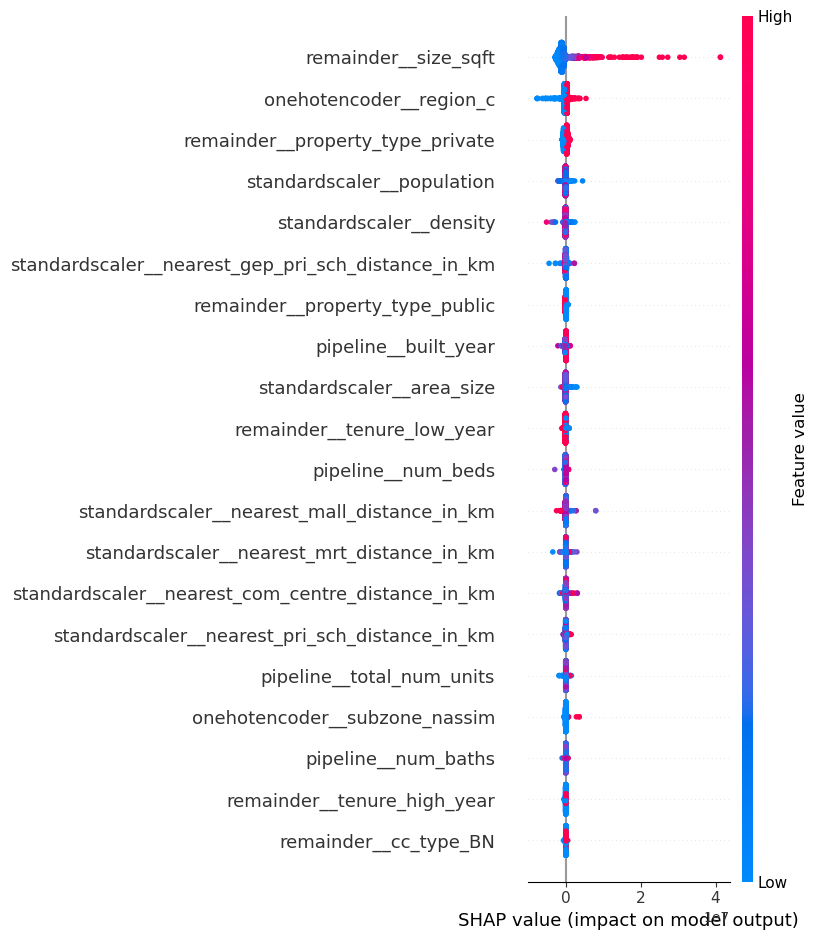

In [56]:
# use a random sample of dataset due to resource limitations
shap_df_train_sample = shap_df_train.copy()

l = [np.argmin(se), np.argmax(se)]
l.extend(range(1000))
shap_df_train_sample = shap_df_train_sample.iloc[l]
# X_train_sample =  X_train[:1000] + + shap_df_train_sample[np.argmax(se)] + shap_df_train_sample[np.argmin(se)]

# cannot fit pipeline model 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_df_train_sample)

shap.summary_plot(shap_values, shap_df_train_sample)

In [57]:
y_pred

array([ 4595756.5,  6628577.5,  3196068.5, ...,  1406772.5,   683403.5,
       16148690. ], dtype=float32)

In [58]:
y_train.iloc[np.argmin(se)], np.array(y_train).reshape(-1, 1)[np.argmin(se)] - 1264594.875, np.sqrt(se[np.argmin(se)])

(1467900.0, array([203305.125]), array([3.125]))

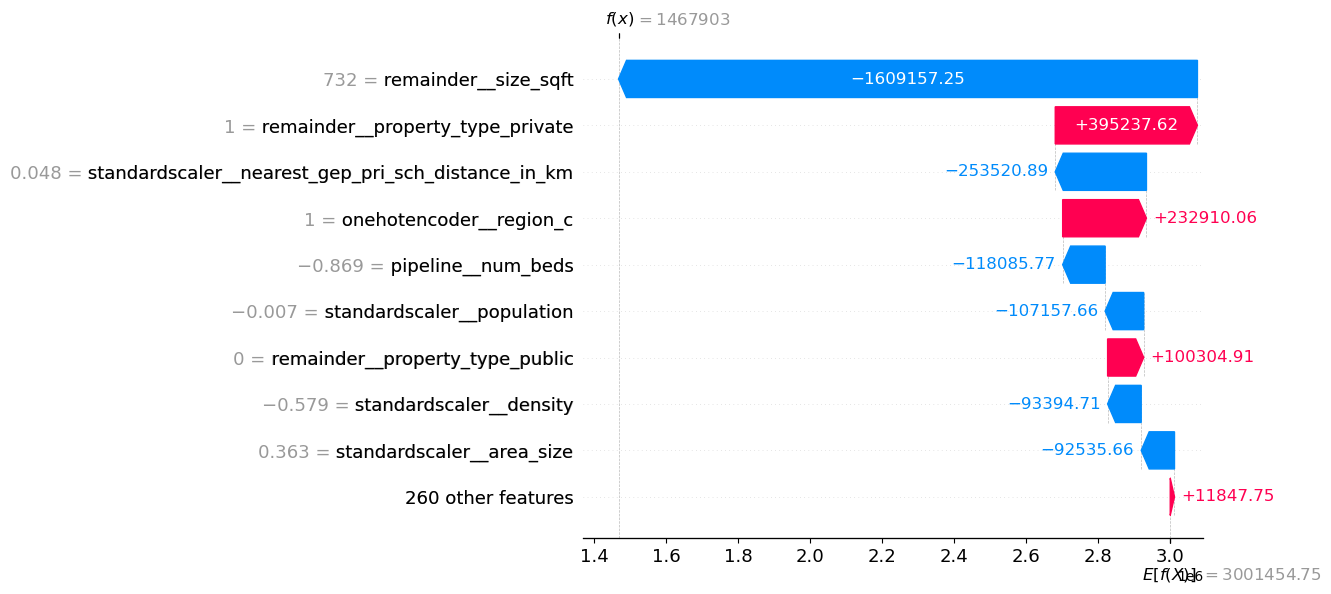

In [59]:
# visualize the first prediction's explanation
shap.plots.waterfall(explainer(shap_df_train_sample)[0])

In [60]:
np.array(y_train).reshape(-1, 1)[np.argmax(se)], np.array(y_train).reshape(-1, 1)[np.argmax(se)] - 8760740, np.sqrt(se[np.argmax(se)])

(array([30880500.]), array([22119760.]), array([23320943.]))

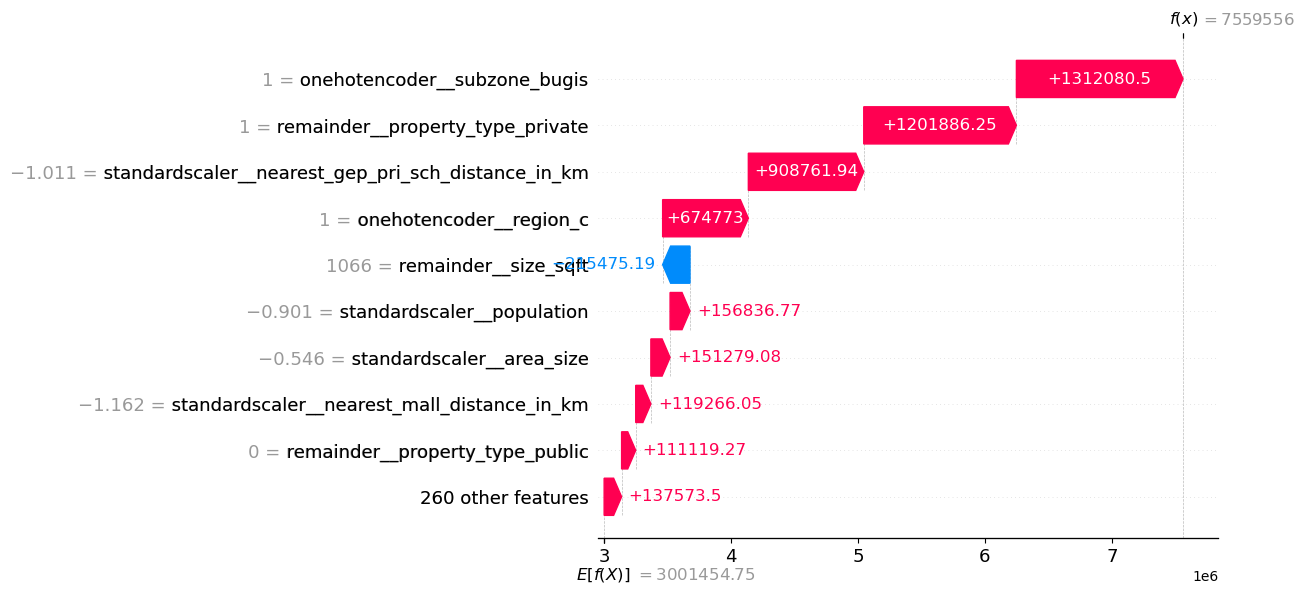

In [61]:
# visualize the first prediction's explanation
shap.plots.waterfall(explainer(shap_df_train_sample)[1])

In [62]:
shap_interactn_values = shap.TreeExplainer(model).shap_interaction_values(shap_df_train_sample)

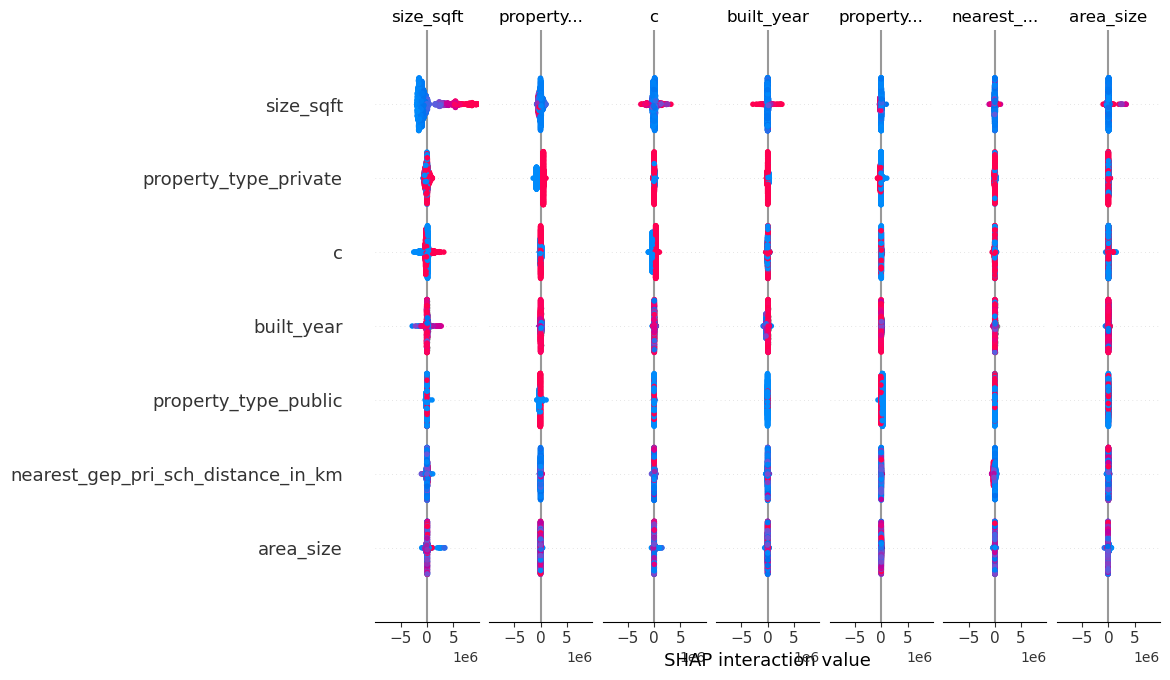

In [ ]:
shap.summary_plot(shap_interactn_values, shap_df_train_sample)

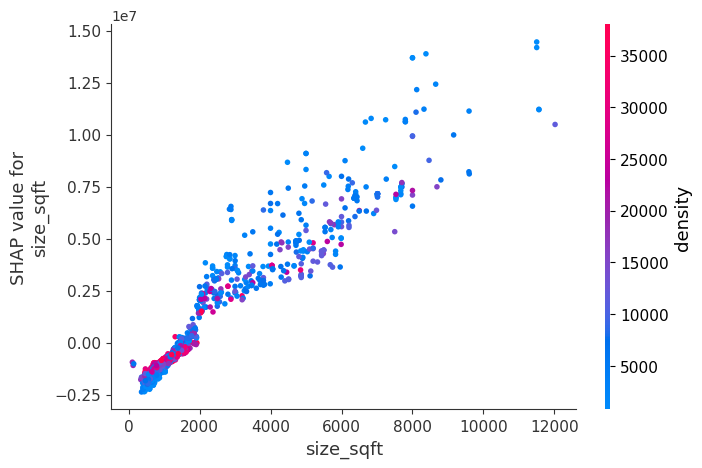

In [ ]:
shap.dependence_plot("size_sqft", shap_values, shap_df_train_sample)

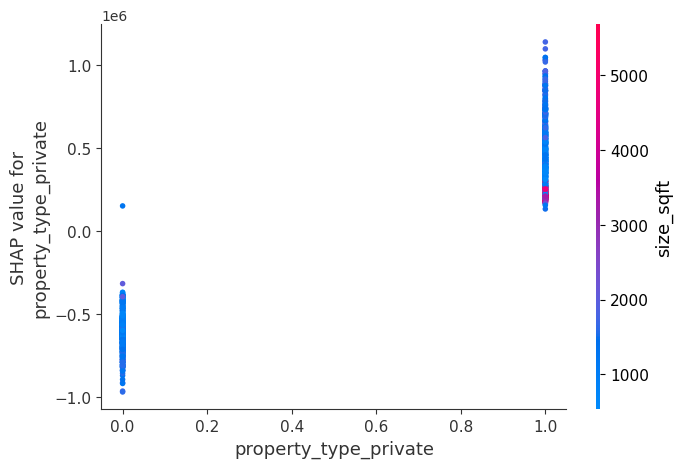

In [ ]:
shap.dependence_plot("property_type_private", shap_values, shap_df_train_sample)

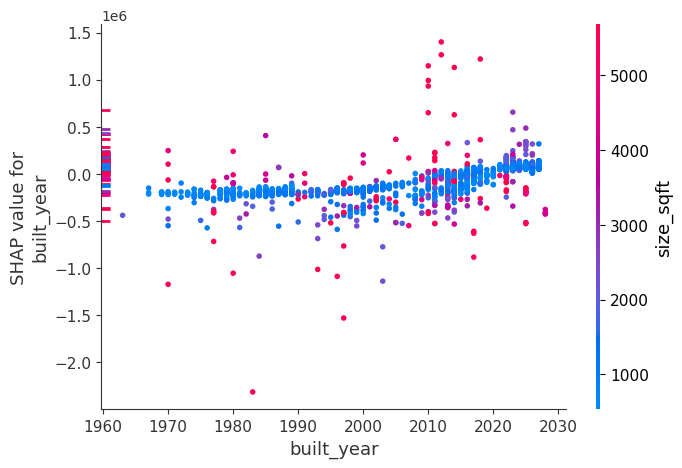

In [ ]:
shap.dependence_plot("built_year", shap_values, shap_df_train_sample)

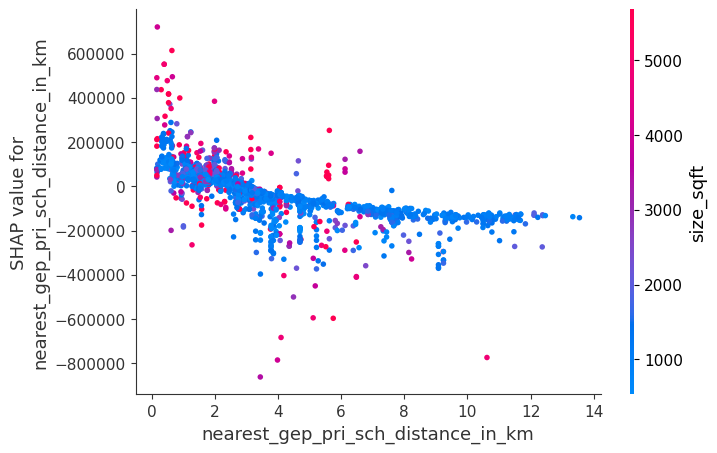

In [ ]:
shap.dependence_plot("nearest_gep_pri_sch_distance_in_km", shap_values, shap_df_train_sample)
